

---

# Weather


---



## Setup

In [82]:
%reset-f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Load Shelter Data

In [2]:
# Import the daily shelter occupancy stats for the years 2017-2019
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
df = pd.read_csv(path+'shelter_use_totals_without_families__daily.csv', parse_dates=['Date'])
df.head()

,Date,capacity,occupancy,vacancy
0,2017-01-01,3503,3265,238
1,2017-01-02,3548,3270,278
2,2017-01-03,3577,3268,309
3,2017-01-04,3607,3396,211
4,2017-01-05,3629,3367,262


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1095 non-null   datetime64[ns]
 1   capacity   1095 non-null   int64         
 2   occupancy  1095 non-null   int64         
 3   vacancy    1095 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.3 KB


In [4]:
# Change the name of the date field to match what I used in functions below
df.rename(columns={'Date': 'Year_Month_Day', 'occupancy': 'OCCUPANCY' }, inplace=True)

In [5]:
# Set the date as a the index
df.set_index('Year_Month_Day', inplace=True)
df.head()

,capacity,OCCUPANCY,vacancy
Year_Month_Day,,,
2017-01-01,3503,3265,238
2017-01-02,3548,3270,278
2017-01-03,3577,3268,309
2017-01-04,3607,3396,211
2017-01-05,3629,3367,262


## Load Weather Data

In [6]:
# *******************************************************
# Add weather data
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Weather%20Data/'
dfw17 = pd.read_csv(path+'en_climate_daily_ON_6158355_2017_P1D.csv', parse_dates=['Date/Time'])
dfw18 = pd.read_csv(path+'en_climate_daily_ON_6158355_2018_P1D.csv', parse_dates=['Date/Time'])
dfw19 = pd.read_csv(path+'en_climate_daily_ON_6158355_2019_P1D.csv', parse_dates=['Date/Time'])

In [7]:
# Concatenate into one dataframe
dfw=pd.concat([dfw17,dfw18,dfw19])
# Clean up missing values - remove them. 
# Remove days with no temp data
#dfw = dfw[dfw.'Max Temp Flag' != 'M']
dfw.drop(dfw.index[dfw['Max Temp Flag'] == 'M'], inplace = True)
dfw.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.4,43.67,TORONTO CITY,6158355,2017-01-01,2017,1,1,NaN,3.1,NaN,-0.5,NaN,1.3,NaN,16.7,NaN,0.0,NaN,NaN,M,NaN,M,0.0,NaN,3.0,NaN,NaN,M,NaN,M
1,-79.4,43.67,TORONTO CITY,6158355,2017-01-02,2017,1,2,NaN,5.5,NaN,0.7,NaN,3.1,NaN,14.9,NaN,0.0,NaN,NaN,M,NaN,M,0.0,NaN,3.0,NaN,NaN,M,NaN,M
2,-79.4,43.67,TORONTO CITY,6158355,2017-01-03,2017,1,3,NaN,4.8,NaN,2.4,NaN,3.6,NaN,14.4,NaN,0.0,NaN,NaN,M,NaN,M,11.3,NaN,1.0,NaN,NaN,M,NaN,M
3,-79.4,43.67,TORONTO CITY,6158355,2017-01-04,2017,1,4,NaN,3.8,NaN,-7.6,NaN,-1.9,NaN,19.9,NaN,0.0,NaN,NaN,M,NaN,M,0.6,NaN,NaN,NaN,NaN,M,NaN,M
4,-79.4,43.67,TORONTO CITY,6158355,2017-01-05,2017,1,5,NaN,-5.3,NaN,-10.3,NaN,-7.8,NaN,25.8,NaN,0.0,NaN,NaN,M,NaN,M,0.0,NaN,NaN,NaN,NaN,M,NaN,M


In [8]:
# Drop empty columns
dfw.drop(['Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 
          'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)',
          'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 
          'Total Precip Flag', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 
          'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'], axis = 1, inplace=True) 
dfw.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust Flag
0,-79.4,43.67,TORONTO CITY,6158355,2017-01-01,2017,1,1,3.1,-0.5,1.3,16.7,0.0,0.0,3.0,M
1,-79.4,43.67,TORONTO CITY,6158355,2017-01-02,2017,1,2,5.5,0.7,3.1,14.9,0.0,0.0,3.0,M
2,-79.4,43.67,TORONTO CITY,6158355,2017-01-03,2017,1,3,4.8,2.4,3.6,14.4,0.0,11.3,1.0,M
3,-79.4,43.67,TORONTO CITY,6158355,2017-01-04,2017,1,4,3.8,-7.6,-1.9,19.9,0.0,0.6,NaN,M
4,-79.4,43.67,TORONTO CITY,6158355,2017-01-05,2017,1,5,-5.3,-10.3,-7.8,25.8,0.0,0.0,NaN,M


## Independent EDA Visualization of Shelter and Weather

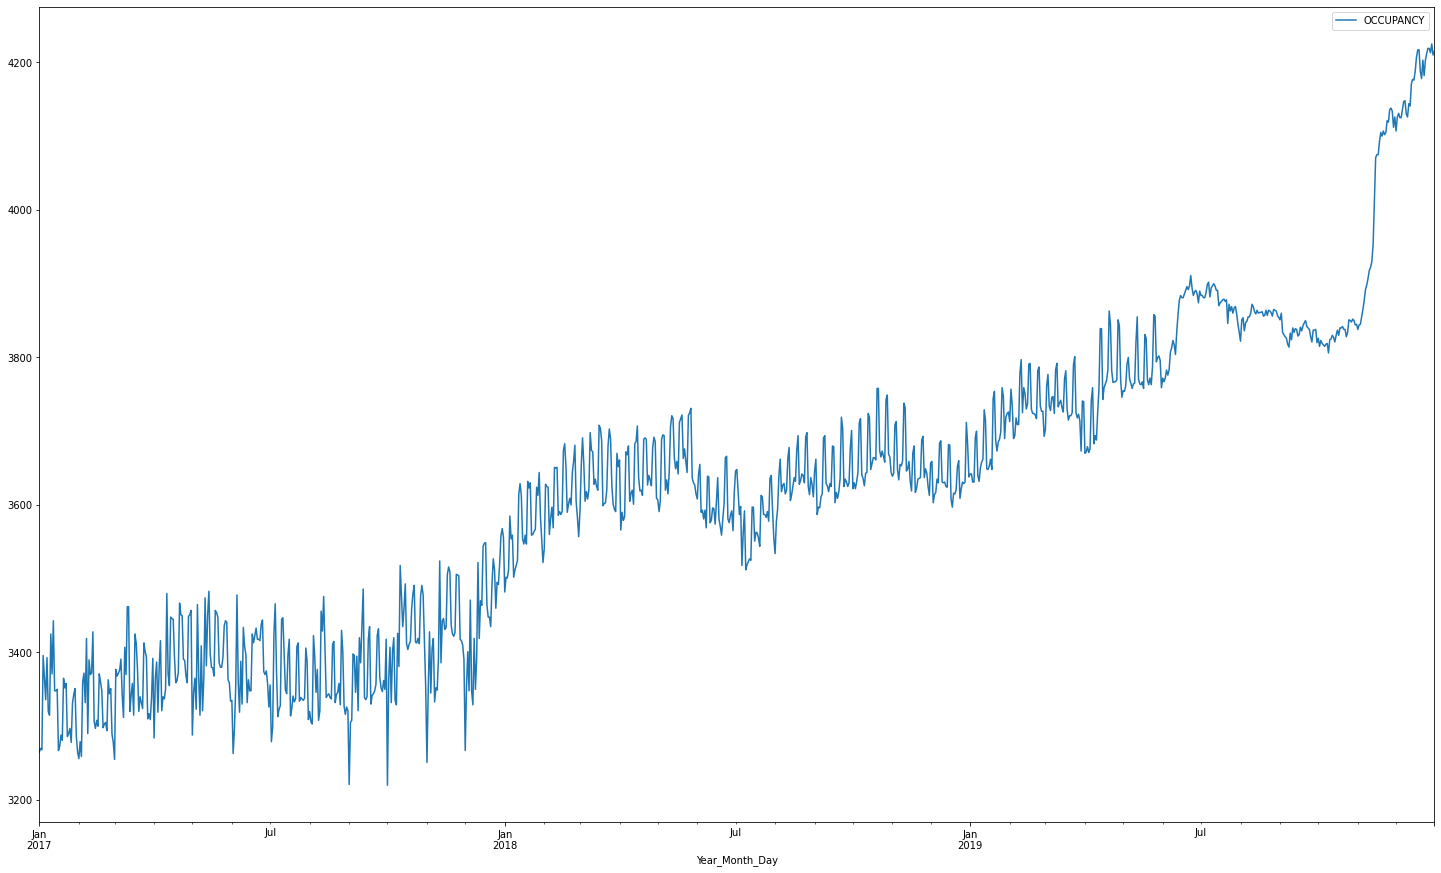

In [9]:
# Plot Occupancy
ax = df.reset_index().plot(x='Year_Month_Day', y='OCCUPANCY', figsize=(25,15))
ax;

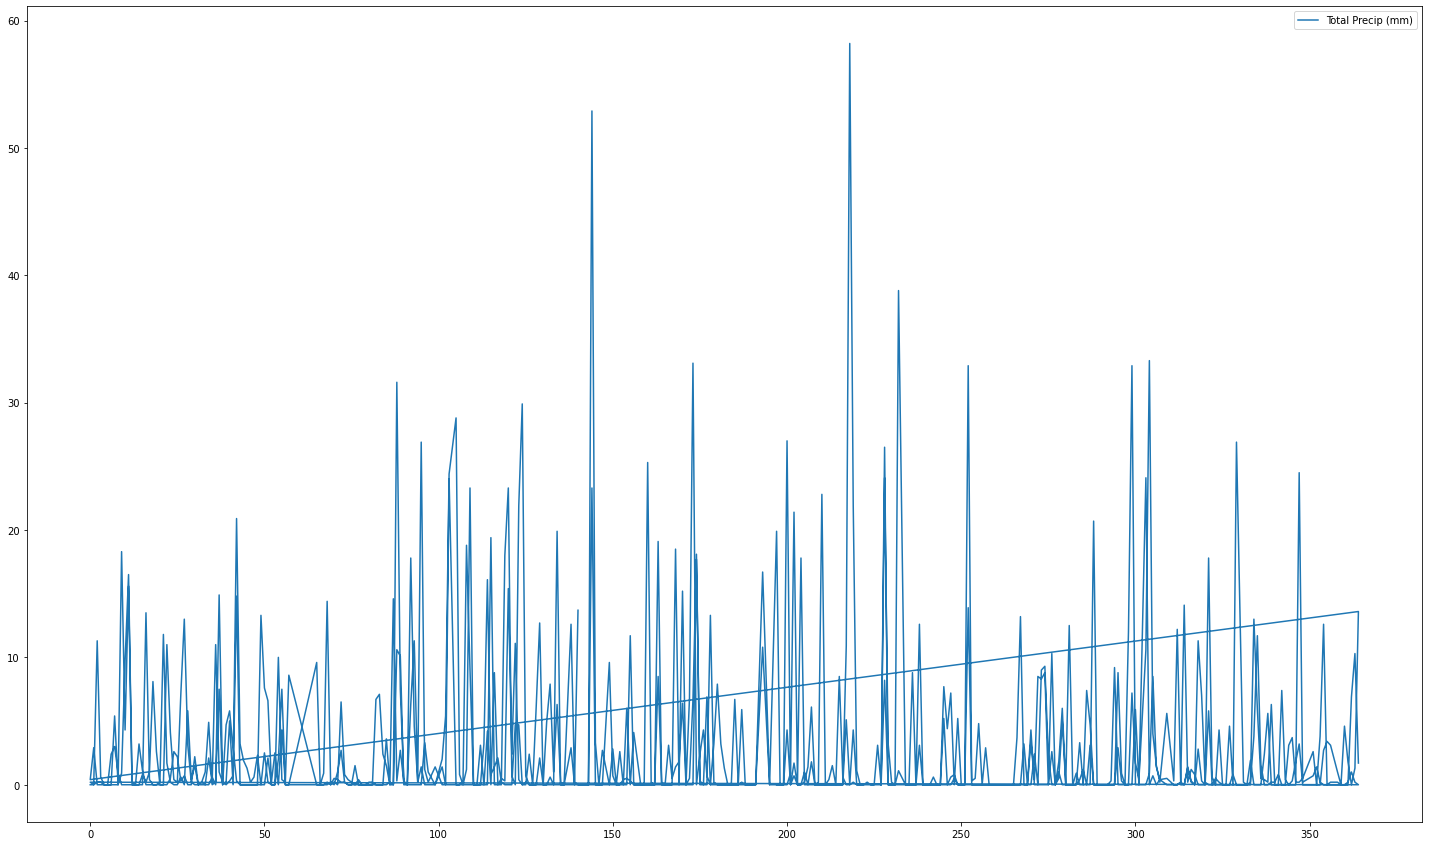

In [10]:
# Long term growth trend, some seasonality seems apparent.
#********************
# Now plot precipitation
axw = dfw.plot(y='Total Precip (mm)', figsize=(25,15))

In [11]:
dfw.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust Flag
0,-79.4,43.67,TORONTO CITY,6158355,2017-01-01,2017,1,1,3.1,-0.5,1.3,16.7,0.0,0.0,3.0,M
1,-79.4,43.67,TORONTO CITY,6158355,2017-01-02,2017,1,2,5.5,0.7,3.1,14.9,0.0,0.0,3.0,M
2,-79.4,43.67,TORONTO CITY,6158355,2017-01-03,2017,1,3,4.8,2.4,3.6,14.4,0.0,11.3,1.0,M
3,-79.4,43.67,TORONTO CITY,6158355,2017-01-04,2017,1,4,3.8,-7.6,-1.9,19.9,0.0,0.6,NaN,M
4,-79.4,43.67,TORONTO CITY,6158355,2017-01-05,2017,1,5,-5.3,-10.3,-7.8,25.8,0.0,0.0,NaN,M


## Merge Shelter and Weather Data

In [12]:
# In preparation for statistical analysis, merge the Weather & Shelter data
dfw.set_index('Date/Time', inplace=True)

In [13]:
print('PRE-MERGE CHECK:',
      np.where(df.index.dtype==dfw.index.dtype,'Index datatypes match. Ready for merge.', 'Index datatypes do not match.  Resolve before merging.')
      )

PRE-MERGE CHECK: Index datatypes match. Ready for merge.


In [14]:
# To run additional analysis, bring the two datasets into a single dataframe
merged_df = pd.concat([df, dfw], axis=1, sort=False)
merged_df.head()

,capacity,OCCUPANCY,vacancy,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust Flag
2017-01-01,3503,3265,238,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,1.0,3.1,-0.5,1.3,16.7,0.0,0.0,3.0,M
2017-01-02,3548,3270,278,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,2.0,5.5,0.7,3.1,14.9,0.0,0.0,3.0,M
2017-01-03,3577,3268,309,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,3.0,4.8,2.4,3.6,14.4,0.0,11.3,1.0,M
2017-01-04,3607,3396,211,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,4.0,3.8,-7.6,-1.9,19.9,0.0,0.6,NaN,M
2017-01-05,3629,3367,262,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,5.0,-5.3,-10.3,-7.8,25.8,0.0,0.0,NaN,M


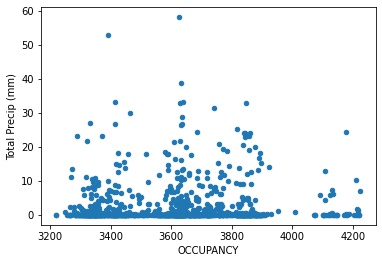

In [15]:
# Scatter plot with Occupancy and Total Precipitation
ax = merged_df.plot.scatter(x='OCCUPANCY', y='Total Precip (mm)')

## Linear Regression

In [16]:
# Run regression analysis on hypothesis 1 (Precipitation)
# For regression analysis we will use the statsmodels package
import statsmodels.formula.api as sm

In [17]:
# For visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

In [18]:
# Let's rename Total Precip(mm) & Min Temp (°C) - it may cause us trouble later
merged_df.rename(columns={'Total Precip (mm)':'TotalPrecipmm', 'Min Temp (°C)':'MinTempCelsius'}, inplace=True)

In [19]:
cm = merged_df.corr(method = 'pearson')

# Print correlation matrix
cm

,capacity,OCCUPANCY,vacancy,Longitude (x),Latitude (y),Climate ID,Year,Month,Day,Max Temp (°C),MinTempCelsius,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),TotalPrecipmm,Snow on Grnd (cm)
capacity,1.000000e+00,9.600173e-01,-5.018454e-01,5.379520e-15,1.136569e-14,NaN,8.774954e-01,1.489256e-01,5.275758e-02,-6.729312e-02,-6.703496e-02,-6.782993e-02,7.596914e-02,-9.556921e-03,2.595372e-02,0.033090
OCCUPANCY,9.600173e-01,1.000000e+00,-7.239170e-01,3.109891e-15,4.966149e-15,NaN,9.013633e-01,2.432101e-01,6.577731e-02,-2.792750e-02,-2.264624e-02,-2.539849e-02,2.954849e-02,8.713995e-04,2.857670e-02,-0.006024
vacancy,-5.018454e-01,-7.239170e-01,1.000000e+00,-2.375593e-15,-1.139529e-14,NaN,-6.254346e-01,-3.840946e-01,-7.328752e-02,-7.893338e-02,-9.463427e-02,-8.810368e-02,9.527909e-02,-2.612471e-02,-2.439028e-02,0.104707
Longitude (x),5.379520e-15,3.109891e-15,-2.375593e-15,1.000000e+00,-1.000000e+00,NaN,0.000000e+00,3.403082e-15,2.128441e-16,-2.364396e-15,4.072147e-16,1.518197e-15,2.009729e-16,-2.554025e-16,3.094822e-16,0.000000
Latitude (y),1.136569e-14,4.966149e-15,-1.139529e-14,-1.000000e+00,1.000000e+00,NaN,0.000000e+00,-1.634138e-15,2.487919e-16,8.554875e-16,-5.128563e-16,-1.336699e-15,-4.474251e-16,8.232029e-16,-2.892305e-16,0.000000
Climate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,8.774954e-01,9.013633e-01,-6.254346e-01,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.915171e-17,4.863428e-19,-2.862729e-02,-3.534055e-02,-3.236573e-02,3.853240e-02,4.655803e-03,2.408778e-02,0.031360
Month,1.489256e-01,2.432101e-01,-3.840946e-01,3.403082e-15,-1.634138e-15,NaN,1.915171e-17,1.000000e+00,-1.430813e-02,2.499536e-01,2.968501e-01,2.751537e-01,-2.833775e-01,1.388538e-01,-1.936537e-02,-0.154480
Day,5.275758e-02,6.577731e-02,-7.328752e-02,2.128441e-16,2.487919e-16,NaN,4.863428e-19,-1.430813e-02,1.000000e+00,1.793156e-02,1.863461e-02,1.852727e-02,-2.006561e-02,5.374963e-03,1.577677e-02,-0.092733
Max Temp (°C),-6.729312e-02,-2.792750e-02,-7.893338e-02,-2.364396e-15,8.554875e-16,NaN,-2.862729e-02,2.499536e-01,1.793156e-02,1.000000e+00,9.613608e-01,9.911819e-01,-9.735045e-01,6.911422e-01,1.831610e-02,-0.425311


In [20]:
# Calculate the means of x, y
mu_x = merged_df["OCCUPANCY"].mean()
mu_y = merged_df["TotalPrecipmm"].mean()

print(mu_x, mu_y)

3618.611872146119 2.454005934718103


In [21]:
# Calculate the standard deviations of x, y
sig_x = merged_df["OCCUPANCY"].std()
sig_y = merged_df["TotalPrecipmm"].std()

print(sig_x, sig_y)

210.7277371415258 5.95645180413759


In [22]:
beta_1 = sig_y/sig_x * cm.loc['OCCUPANCY', 'TotalPrecipmm']
beta_0 = mu_y - beta_1 * mu_x

print(beta_0, beta_1)

-0.4689350568064503 0.0008077520040277272


In [23]:
#Fit the regression model using the OLS method
# Initialize the regression model
m = sm.ols('TotalPrecipmm ~ OCCUPANCY', data = merged_df)

In [24]:
# Fit the regression model
m = m.fit()

In [25]:
# Print the regression parameters
m.params

Intercept   -0.472353
OCCUPANCY    0.000808
dtype: float64

In [26]:
# Visualize our results.
# Calculate estimates of y

intercept, slope = m.params
merged_df['y_est'] = intercept + slope * merged_df.OCCUPANCY

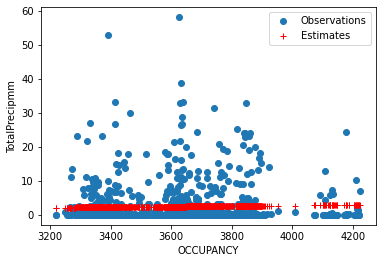

In [27]:
# Plot the estimates along the actual observations
plt.plot(merged_df.OCCUPANCY, merged_df.TotalPrecipmm, 'o', label = 'Observations')
plt.xlabel('OCCUPANCY')
plt.ylabel('TotalPrecipmm')

# Draw estimates
plt.plot(merged_df.OCCUPANCY, merged_df.y_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [28]:
# Show the model summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TotalPrecipmm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8247
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.364
Time:                        20:42:43   Log-Likelihood:                -3237.7
No. Observations:                1011   AIC:                             6479.
Df Residuals:                    1009   BIC:                             6489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4724      3.228     -0.146      0.884      -6.807       5.862
OCCUPANCY      0.0008      0.001      0.908      0.364      -0.001       0.003
==============================================================================
Omnibus:                      851.660   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19070.256
Skew:                           3.867   Prob(JB):                         0.00
Kurtosis:                      22.821   Cond. No.                     6.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# No relationship. Try hypothesis #2 - negative relationship between minimum daily temperature
# and occupancy

In [30]:
# Same x, input a new y
mu_y2 = merged_df["MinTempCelsius"].mean()

print(mu_x, mu_y2)

3618.611872146119 5.921730580137663


In [31]:
# Calculate the standard deviations of the new y

sig_y2 = merged_df["MinTempCelsius"].std()

print(sig_x, sig_y2)

210.7277371415258 9.91449814060688


In [32]:
beta_1 = sig_y2/sig_x * cm.loc['OCCUPANCY', 'MinTempCelsius']
beta_0 = mu_y2 - beta_1 * mu_x

print(beta_0, beta_1)

9.777287453164925 -0.001065479528961092


In [33]:
#Fit the regression model using the OLS method
# Initialize the regression model

m = sm.ols('MinTempCelsius ~ OCCUPANCY', data = merged_df)

In [34]:
# Fit the regression model
m = m.fit()

In [35]:
# Print the regression parameters
m.params

Intercept    9.780576
OCCUPANCY   -0.001066
dtype: float64

In [36]:
# Visualize our results.
# Calculate estimates of y2

intercept, slope = m.params
merged_df['y2_est'] = intercept + slope * merged_df.OCCUPANCY

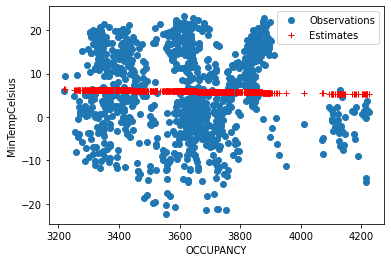

In [37]:
# Plot the estimates along the actual observations

plt.plot(merged_df.OCCUPANCY, merged_df.MinTempCelsius, 'o', label = 'Observations')
plt.xlabel('OCCUPANCY')
plt.ylabel('MinTempCelsius')

# Draw estimates
plt.plot(merged_df.OCCUPANCY, merged_df.y2_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [38]:
# Visually a very slight negative relationship
# Show the model summary 
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MinTempCelsius   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5208
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.471
Time:                        20:42:43   Log-Likelihood:                -3775.3
No. Observations:                1017   AIC:                             7555.
Df Residuals:                    1015   BIC:                             7564.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7806      5.356      1.826      0.068      -0.730      20.291
OCCUPANCY     -0.0011      0.001     -0.722      0.471      -0.004       0.002
==============================================================================
Omnibus:                       63.294   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.253
Skew:                          -0.300   Prob(JB):                     2.21e-08
Kurtosis:                       2.313   Cond. No.                     6.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# No correlation at all

In [40]:
# What's the main problem? Growing capacity is driving Occupancy
# We need to de-trend this data. We'll try two methods
# 1. Statistical
# 2. Taking a sample where capacity is held constant.

# *********************************************************
# 1. Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
# We'll use additive & multiplicative decomposition then compare.
merged_df.interpolate(inplace = True)
#merged_df.index=merged_df.index.to_timestamp()
result_mul = seasonal_decompose(merged_df['OCCUPANCY'], model='multiplicative')

# And to compare, do Additive as well
# Additive model
result_add = seasonal_decompose(merged_df['OCCUPANCY'], model='additive')

<Figure size 1440x720 with 0 Axes>

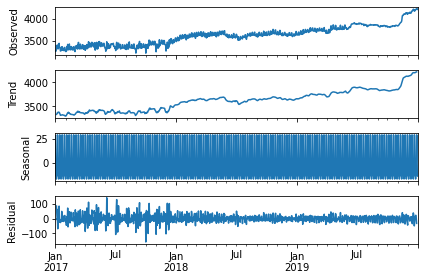

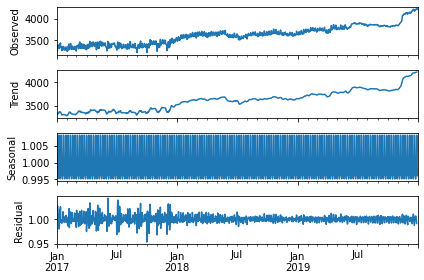

In [41]:
plt.figure(figsize=(20,10))
p1 = result_add.plot()
p2 = result_mul.plot()
plt.show()

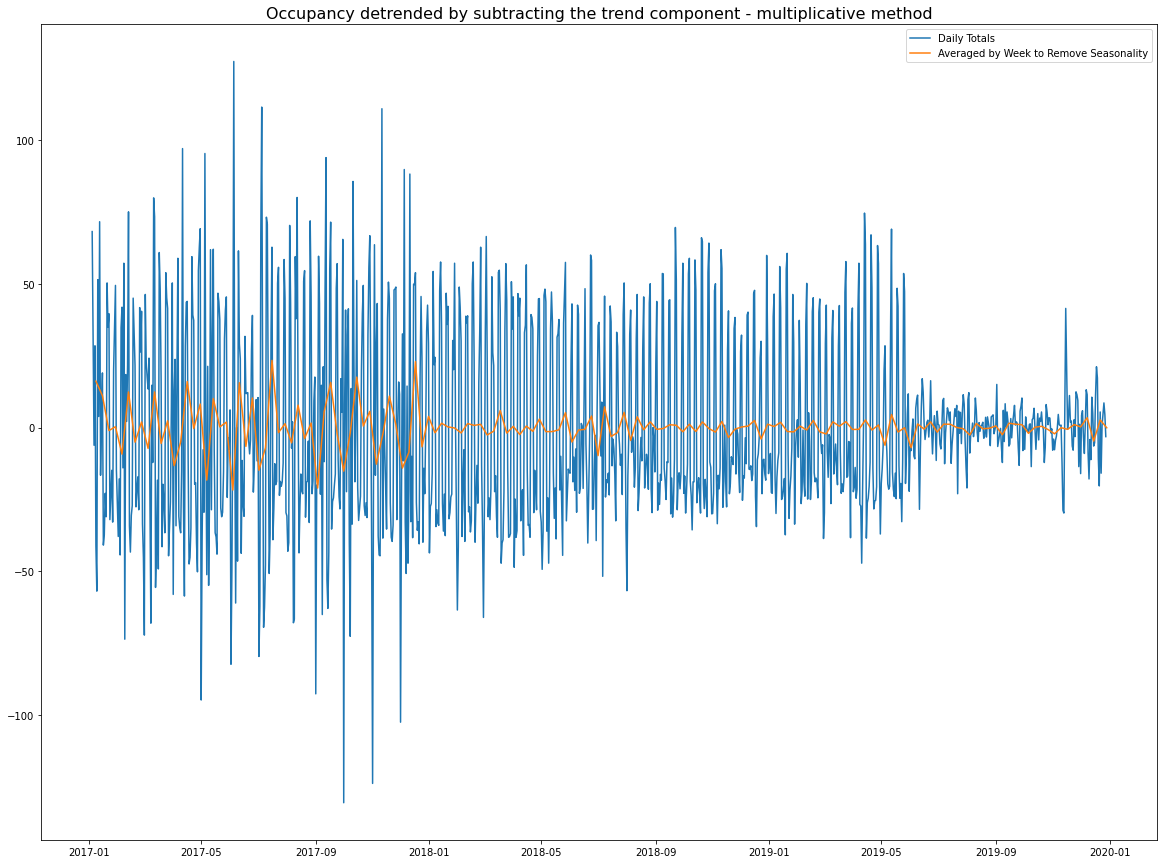

In [42]:
detrended_mul = merged_df.OCCUPANCY.values - result_mul.trend
detrended_add = merged_df.OCCUPANCY.values - result_add.trend
fig=plt.figure(figsize=(20,15))
plt.plot(detrended_mul)
plt.plot(detrended_mul.resample('W').mean())
plt.legend(['Daily Totals','Averaged by Week to Remove Seasonality'])
plt.title('Occupancy detrended by subtracting the trend component - multiplicative method', fontsize=16);

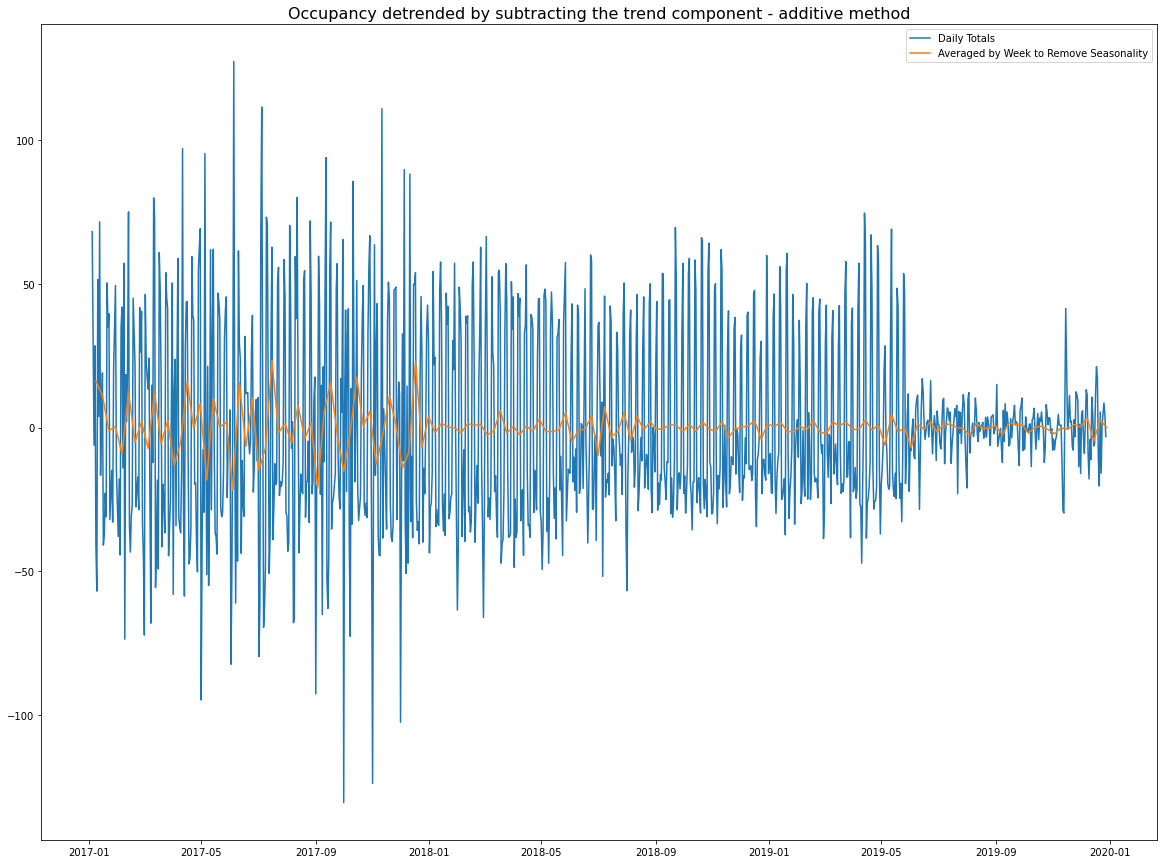

In [43]:
fig=plt.figure(figsize=(20,15))
plt.plot(detrended_add)
plt.plot(detrended_add.resample('W').mean())
plt.legend(['Daily Totals','Averaged by Week to Remove Seasonality'])
plt.title('Occupancy detrended by subtracting the trend component - additive method', fontsize=16);

In [44]:
# Ok, the transformation has successfully removed the growth trend. The Occupancy though
# though it highly erratic through to May 2019 for some reason.
# Check to see if remaining noise is white noise
# Take the residuals and remove NaNs
residual1 = result_mul.resid.dropna()
residual2 = result_add.resid.dropna()

In [45]:
# Calculate means
mu1 = residual1.mean()
mu2 = residual2.mean()

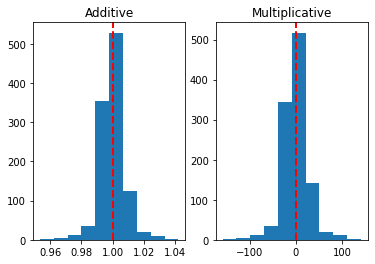

In [46]:
# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(residual1)
ax2.hist(residual2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

# Add vertical lines to highlight the means
ax1.axvline(x = mu1, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

ax2.axvline(x = mu2, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

plt.show()

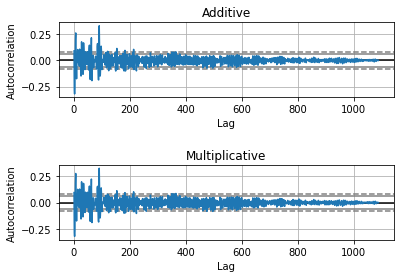

In [47]:
# Results are very similar - spread is nearly identical. 
# Assess the independence by calculating autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1)

pd.plotting.autocorrelation_plot(residual1, ax = ax1)
pd.plotting.autocorrelation_plot(residual2, ax = ax2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

plt.subplots_adjust(hspace = 0.9)
plt.show()

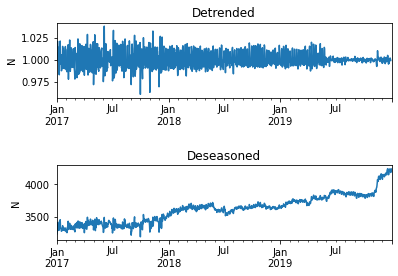

In [48]:
# Both models show similar autocorrelation. Either model could be used.
# Remove the trend from the signal a different way
merged_df['detrended'] = merged_df.OCCUPANCY / result_mul.trend
merged_df['deseasoned'] = merged_df.OCCUPANCY / result_mul.seasonal

fix, (ax1, ax2) = plt.subplots(2, 1)
merged_df['detrended'].plot(ax = ax1)
merged_df['deseasoned'].plot(ax = ax2)

ax1.set_ylabel('N')
ax2.set_ylabel('N')

ax1.set_title('Detrended')
ax2.set_title('Deseasoned')

plt.subplots_adjust(hspace = 0.9)
plt.show()

In [49]:
trend_strength = 1. - np.var(result_mul.resid) / np.var(result_mul.resid * result_mul.trend)
seasonality_strength = 1. - np.var(result_mul.resid) / np.var(result_mul.resid + result_mul.seasonal)

In [50]:
print ('Strength of trend is: %1.3f' % trend_strength)
print ('Strength of seasonality is: %1.3f' % seasonality_strength)

Strength of trend is: 1.000
Strength of seasonality is: 0.309


- The strength of the trend is far greater than the strength of seasonality
- So we'll use de-trended data to do OLS Regression

In [51]:
# Print correlation matrix
cm = merged_df.corr(method = 'pearson')
cm

,capacity,OCCUPANCY,vacancy,Longitude (x),Latitude (y),Climate ID,Year,Month,Day,Max Temp (°C),MinTempCelsius,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),TotalPrecipmm,Snow on Grnd (cm),y_est,y2_est,detrended,deseasoned
capacity,1.000000e+00,9.600173e-01,-5.018454e-01,-6.494116e-15,-9.504516e-15,NaN,8.762745e-01,1.507538e-01,5.265180e-02,-7.927908e-02,-8.258603e-02,-8.197664e-02,9.181870e-02,-1.137309e-02,2.687045e-02,2.079127e-01,9.600173e-01,-9.600173e-01,2.591181e-02,9.640440e-01
OCCUPANCY,9.600173e-01,1.000000e+00,-7.239170e-01,-1.510143e-14,1.904776e-15,NaN,8.996592e-01,2.455493e-01,6.546114e-02,-3.976223e-02,-3.823994e-02,-3.970905e-02,4.610282e-02,1.110307e-03,3.111807e-02,1.586527e-01,1.000000e+00,-1.000000e+00,1.647544e-01,9.958368e-01
vacancy,-5.018454e-01,-7.239170e-01,1.000000e+00,-3.307839e-15,1.174912e-14,NaN,-6.202614e-01,-3.871768e-01,-7.250573e-02,-7.251889e-02,-8.537209e-02,-7.933108e-02,8.383050e-02,-3.145852e-02,-2.992859e-02,2.217798e-02,-7.239170e-01,7.239170e-01,-4.413074e-01,-7.011302e-01
Longitude (x),-6.494116e-15,-1.510143e-14,-3.307839e-15,1.000000e+00,-1.000000e+00,NaN,0.000000e+00,4.602386e-15,-9.135818e-17,-5.493300e-16,3.090856e-16,6.924105e-16,1.591573e-15,2.529647e-17,1.740271e-16,-2.459928e-17,-3.956454e-14,-8.277329e-15,-5.007081e-14,-2.995047e-15
Latitude (y),-9.504516e-15,1.904776e-15,1.174912e-14,-1.000000e+00,1.000000e+00,NaN,0.000000e+00,7.264655e-16,-6.072887e-19,7.059045e-16,-3.581682e-17,-9.203783e-16,-8.911249e-16,2.874512e-17,-1.657627e-16,-3.382650e-16,3.926853e-14,8.761835e-15,5.007071e-14,3.123122e-15
Climate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,8.762745e-01,8.996592e-01,-6.202614e-01,0.000000e+00,0.000000e+00,NaN,1.000000e+00,-1.092516e-17,4.590478e-19,-3.954848e-02,-4.802260e-02,-4.447651e-02,5.319534e-02,7.582545e-03,2.828651e-02,1.963750e-01,8.996592e-01,-8.996592e-01,-5.789073e-03,9.035371e-01
Month,1.507538e-01,2.455493e-01,-3.871768e-01,4.602386e-15,7.264655e-16,NaN,-1.092516e-17,1.000000e+00,-1.059205e-02,2.340387e-01,2.797119e-01,2.582119e-01,-2.645518e-01,1.361962e-01,-2.526075e-02,-1.988561e-01,2.455493e-01,-2.455493e-01,-2.461896e-03,2.457844e-01
Day,5.265180e-02,6.546114e-02,-7.250573e-02,-9.135818e-17,-6.072887e-19,NaN,4.590478e-19,-1.059205e-02,1.000000e+00,1.633331e-02,1.593222e-02,1.631799e-02,-1.800360e-02,3.377134e-03,2.297620e-02,-4.589905e-02,6.546114e-02,-6.546114e-02,6.860823e-02,6.568431e-02
Max Temp (°C),-7.927908e-02,-3.976223e-02,-7.251889e-02,-5.493300e-16,7.059045e-16,NaN,-3.954848e-02,2.340387e-01,1.633331e-02,1.000000e+00,9.621512e-01,9.912760e-01,-9.738709e-01,6.927615e-01,1.283036e-02,-4.618157e-01,-3.976223e-02,3.976223e-02,-2.580512e-02,-3.774928e-02


In [52]:
# Calculate the means of x, y
mu_x = merged_df["detrended"].mean()
mu_y = merged_df["TotalPrecipmm"].mean()

print(mu_x, mu_y)

1.00002056909523 2.482328767123289


In [53]:
# Calculate the standard deviations of x, y
sig_x = merged_df["detrended"].std()
sig_y = merged_df["TotalPrecipmm"].std()

print(sig_x, sig_y)

0.009541850853523905 5.8646930416138305


In [54]:
beta_1 = sig_y/sig_x * cm.loc['detrended', 'TotalPrecipmm']
beta_0 = mu_y - beta_1 * mu_x

print(beta_0, beta_1)

-19.558948466430454 22.040823873748536


In [55]:
#Fit the regression model using the OLS method
# Initialize the regression model
m = sm.ols('TotalPrecipmm ~ detrended', data = merged_df)

In [56]:
# Fit the regression model
m = m.fit()

In [57]:
# Print the regression parameters
m.params

Intercept   -19.58326
detrended    22.05108
dtype: float64

In [58]:
# Visualize our results.
# Calculate estimates of y
intercept, slope = m.params
merged_df['y_est'] = intercept + slope * merged_df.detrended

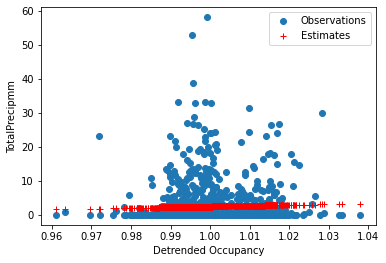

In [59]:
# Plot the estimates along the actual observations
plt.plot(merged_df.detrended, merged_df.TotalPrecipmm, 'o', label = 'Observations')
plt.xlabel('Detrended Occupancy')
plt.ylabel('TotalPrecipmm')

# Draw estimates
plt.plot(merged_df.detrended, merged_df.y_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [60]:
# Show the model summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TotalPrecipmm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.400
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.237
Time:                        20:42:49   Log-Likelihood:                -3470.9
No. Observations:                1089   AIC:                             6946.
Df Residuals:                    1087   BIC:                             6956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5833     18.640     -1.051      0.294     -56.158      16.991
detrended     22.0511     18.639      1.183      0.237     -14.521      58.623
==============================================================================
Omnibus:                      912.100   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20504.665
Skew:                           3.849   Prob(JB):                         0.00
Kurtosis:                      22.815   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

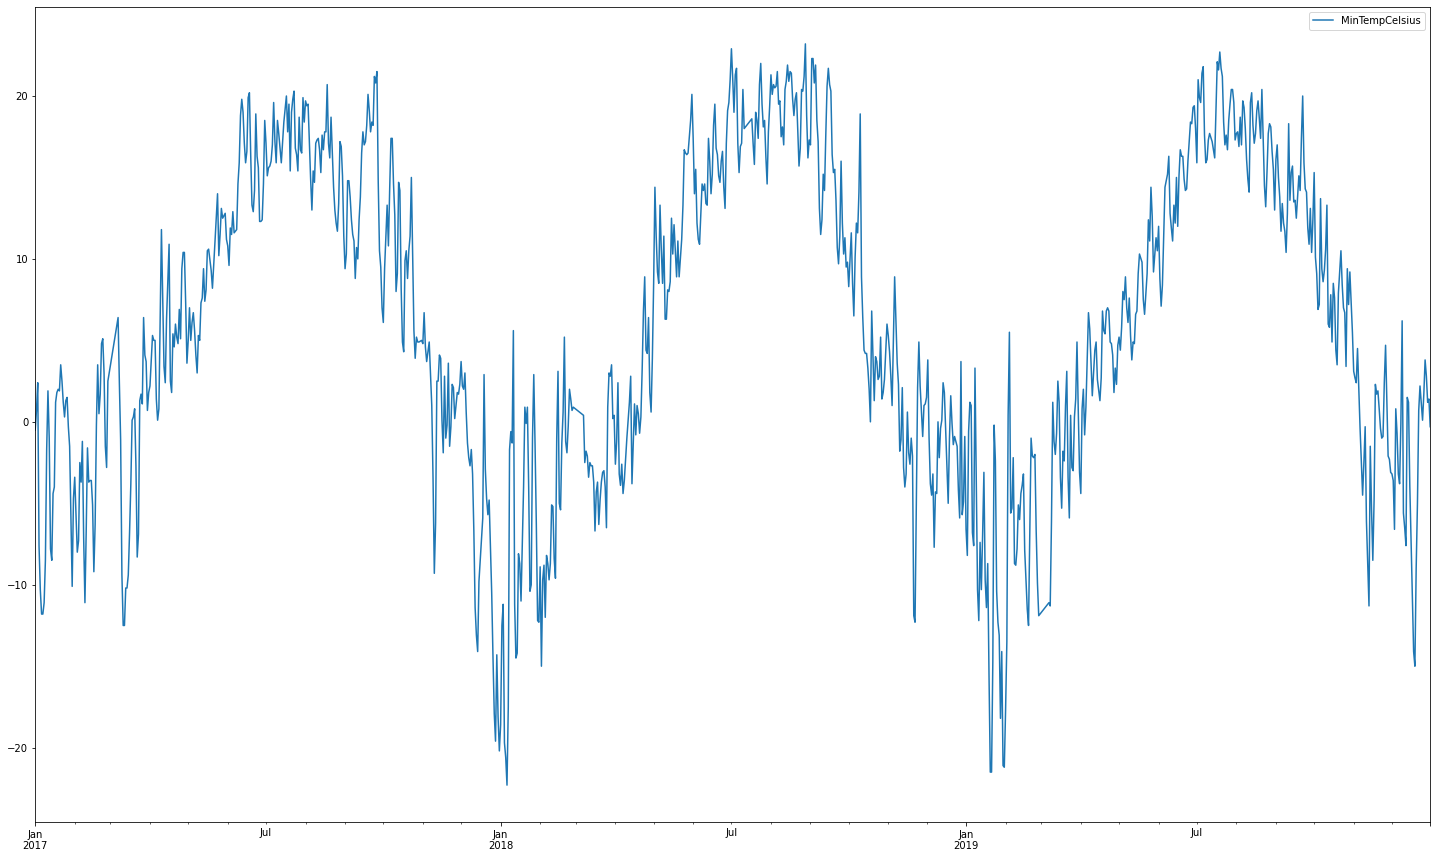

In [61]:
# The R-squared and Adjusted R-squared values show no correlation at all between Total
# Precipitation and the detrended Occupancy data.

# Let's do the same with temperature.
# Now plot temperature
axw = merged_df.plot(y='MinTempCelsius', figsize=(25,15))

In [62]:
# Same x, input a new y
mu_y2 = merged_df["MinTempCelsius"].mean()

print(mu_x, mu_y2)

1.00002056909523 5.844474885844754


In [63]:
# Calculate the standard deviations of the new y
sig_y2 = merged_df["MinTempCelsius"].std()

print(sig_x, sig_y2)

0.009541850853523905 9.856542861126368


In [64]:
beta_1 = sig_y2/sig_x * cm.loc['detrended', 'MinTempCelsius']
beta_0 = mu_y2 - beta_1 * mu_x

print(beta_0, beta_1)

28.787459685187088 -22.94251289260983


In [65]:
#Fit the regression model using the OLS method
# Initialize the regression model

m2 = sm.ols('MinTempCelsius ~ detrended', data = merged_df)

In [66]:
# Fit the regression model
m2 = m2.fit()

In [67]:
# Print the regression parameters
m2.params

Intercept    28.861175
detrended   -22.988526
dtype: float64

In [68]:
# Visualize our results.
# Calculate estimates of y2

intercept, slope = m2.params
merged_df['y2_est'] = intercept + slope * merged_df.detrended

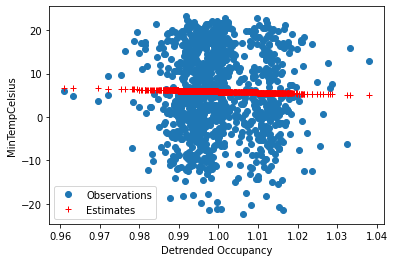

In [69]:
# Plot the estimates along the actual observations

plt.plot(merged_df.detrended, merged_df.MinTempCelsius, 'o', label = 'Observations')
plt.xlabel('Detrended Occupancy')
plt.ylabel('MinTempCelsius')

# Draw estimates
plt.plot(merged_df.detrended, merged_df.y2_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [70]:
# Show the model summary for Extreme Cold
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MinTempCelsius   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5365
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.464
Time:                        20:42:50   Log-Likelihood:                -4038.4
No. Observations:                1089   AIC:                             8081.
Df Residuals:                    1087   BIC:                             8091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.8612     31.388      0.919      0.358     -32.727      90.450
detrended    -22.9885     31.386     -0.732      0.464     -84.573      38.596
==============================================================================
Omnibus:                       71.431   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.029
Skew:                          -0.293   Prob(JB):                     5.52e-09
Kurtosis:                       2.296   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
# No correlation at all.
# Last attempt - isolate the days with some precipitation (precip >= 2mm) and the tempurature is near freezing
# (-10 to +1)
NearZero_Precip = merged_df[(merged_df['TotalPrecipmm'] >= 2) & (merged_df['MinTempCelsius'] >-10) & (merged_df['MinTempCelsius'] <= 1)]

In [72]:
NearZero_Precip.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2017-01-10 to 2019-12-06
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   capacity              53 non-null     int64  
 1   OCCUPANCY             53 non-null     int64  
 2   vacancy               53 non-null     int64  
 3   Longitude (x)         53 non-null     float64
 4   Latitude (y)          53 non-null     float64
 5   Station Name          50 non-null     object 
 6   Climate ID            53 non-null     float64
 7   Year                  53 non-null     float64
 8   Month                 53 non-null     float64
 9   Day                   53 non-null     float64
 10  Max Temp (°C)         53 non-null     float64
 11  MinTempCelsius        53 non-null     float64
 12  Mean Temp (°C)        53 non-null     float64
 13  Heat Deg Days (°C)    53 non-null     float64
 14  Cool Deg Days (°C)    53 non-null     float64
 15  Total

In [73]:
NearZero_Precip.head()

,capacity,OCCUPANCY,vacancy,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Max Temp (°C),MinTempCelsius,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),TotalPrecipmm,Snow on Grnd (cm),Dir of Max Gust Flag,y_est,y2_est,detrended,deseasoned
2017-01-10,3547,3425,122,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,10.0,7.1,-1.7,2.7,15.3,0.0,18.3,0.5625,M,2.803979,5.522199,1.015245,3438.582562
2017-01-12,3647,3443,204,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,12.0,9.8,-1.0,4.4,13.6,0.0,15.6,0.4375,M,2.935938,5.384630,1.021229,3455.653116
2017-01-31,3543,3265,278,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,1.0,31.0,-1.6,-4.7,-3.2,21.2,0.0,2.2,0.0000,M,2.290761,6.057236,0.991970,3277.948048
2017-02-07,3602,3419,183,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,2.0,7.0,4.8,-1.2,1.8,16.2,0.0,14.9,0.5000,M,2.842631,5.481904,1.016997,3432.558767
2017-02-10,3562,3370,192,-79.4,43.67,TORONTO CITY,6158355.0,2017.0,2.0,10.0,-0.2,-6.7,-3.5,21.5,0.0,5.0,0.0000,M,2.481850,5.858022,1.000636,3368.783769


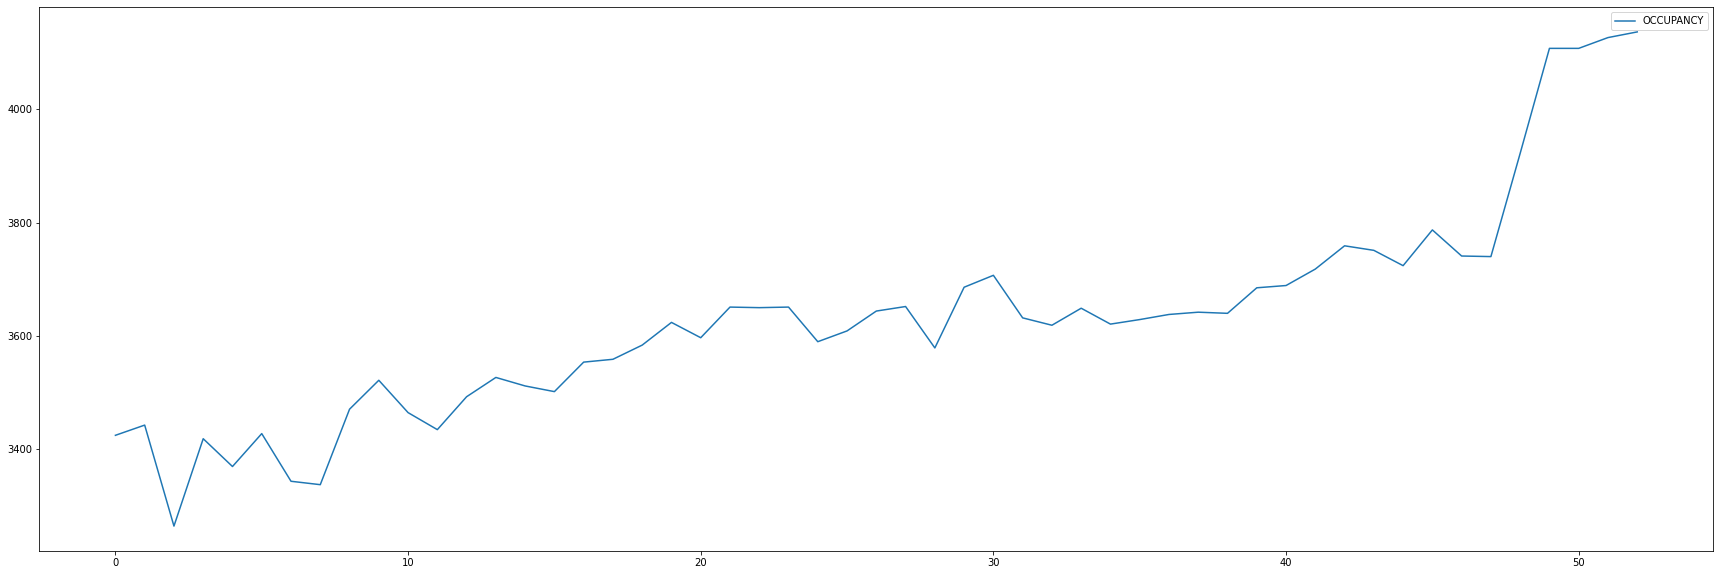

In [74]:
ax5 = NearZero_Precip.reset_index().plot(y='OCCUPANCY',figsize=(30,10))

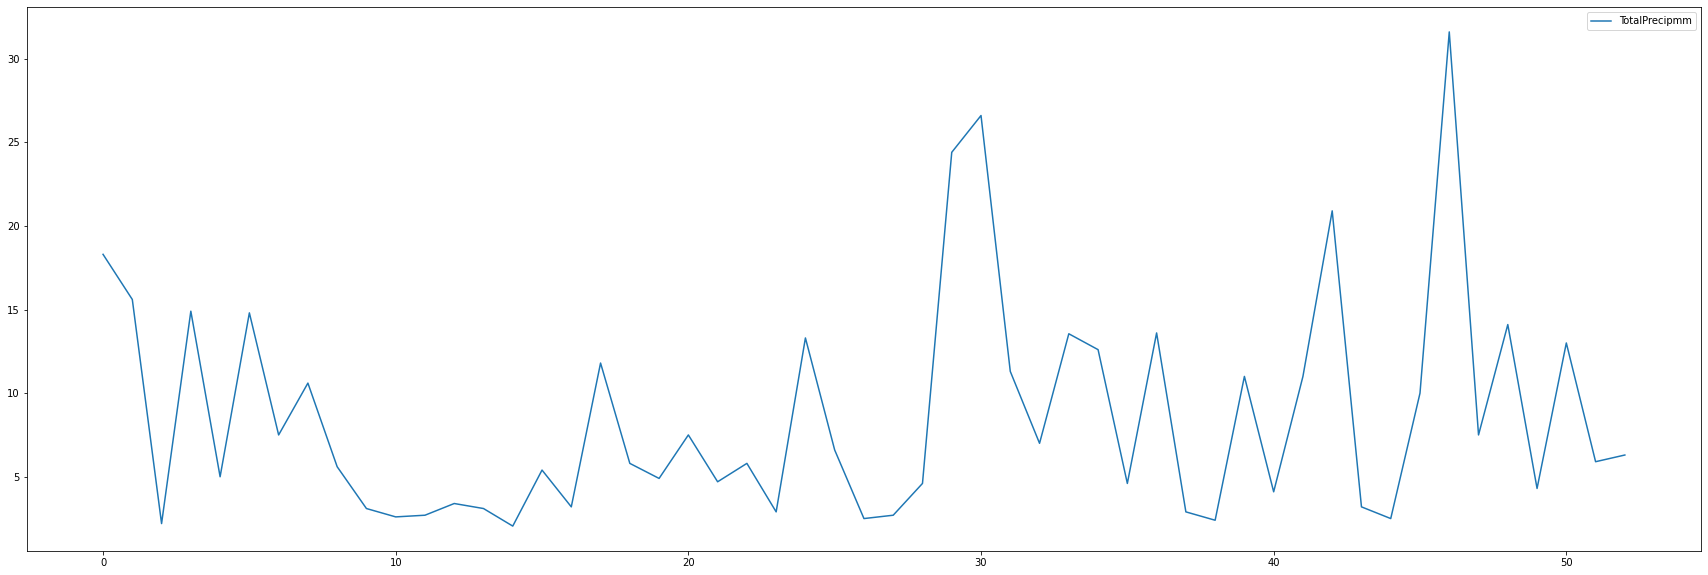

In [75]:
ax6 = NearZero_Precip.reset_index().plot(y='TotalPrecipmm',figsize=(30,10))

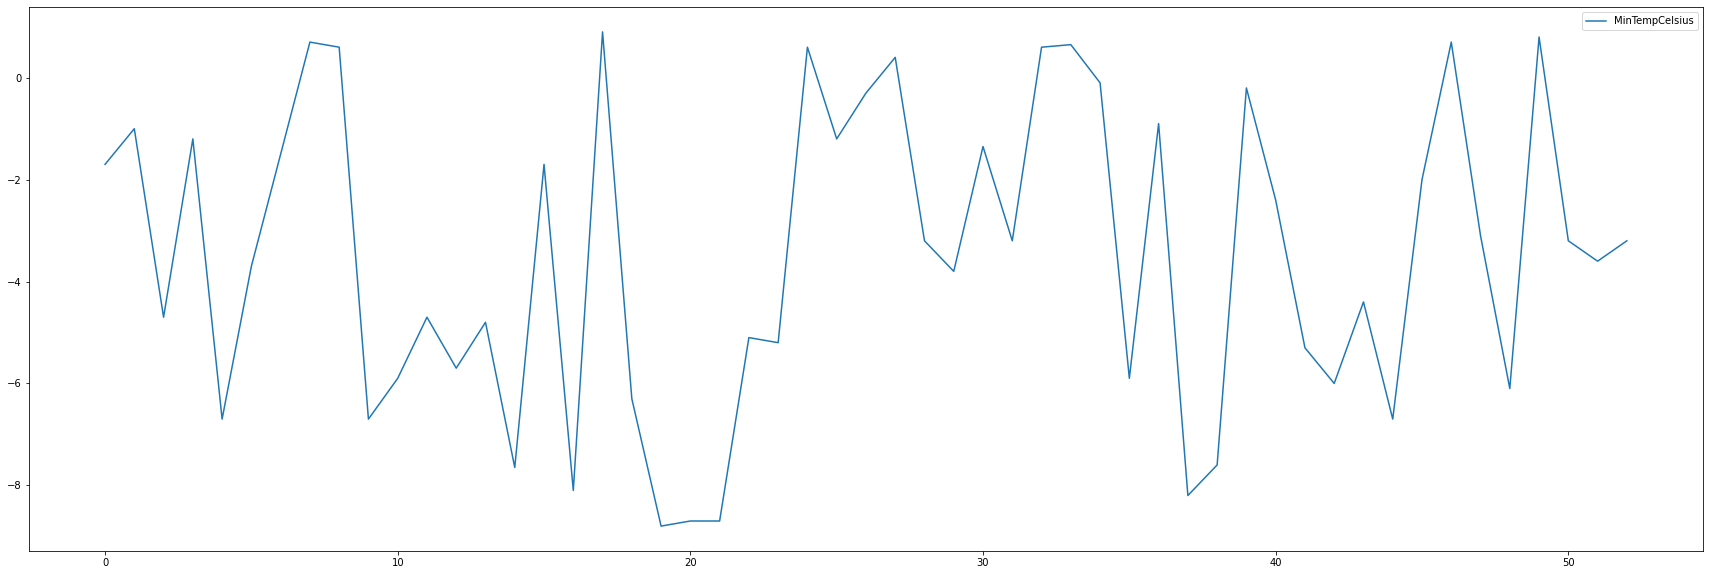

In [76]:
ax5 = NearZero_Precip.reset_index().plot(y='MinTempCelsius',figsize=(30,10))

In [77]:
# Apply multiple regression
from sklearn import linear_model
# here we have 2 variables for multiple regression.
X = NearZero_Precip[['TotalPrecipmm','MinTempCelsius']] 
Y = NearZero_Precip['OCCUPANCY']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 3599.1671457718353
Coefficients: 
 [ 3.232691   -0.66748926]


In [79]:
import statsmodels.api as sm2

model = sm2.OLS(Y, X).fit()
predictions = model.predict(X) 

In [80]:
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:              OCCUPANCY   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.828
Method:                 Least Squares   F-statistic:                              128.8
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                    1.16e-20
Time:                        20:42:52   Log-Likelihood:                         -462.01
No. Observations:                  53   AIC:                                      928.0
Df Residuals:                      51   BIC:                                      932.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [81]:
# Strong R-squared & adjusted R-squared values, so there's correlation. A future study would
# delve deeper into the nature of the correlation and looking at the impact of the variables
# using either backward elimination or forward selection